In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Cannot load cv2.


Setting environment for Precision WorkStation
rm -rf /media/yuncong/BstemAtlasData/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt && mkdir -p /media/yuncong/BstemAtlasData/CSHL_data_processed/MD635

No vtk
Child returned 0
Child returned 1
0.72 seconds.
File does not exist: /media/yuncong/BstemAtlasData/CSHL_data_processed//MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt
File does not exist: /media/yuncong/BstemAtlasData/CSHL_data_processed//MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt
Cannot load cv2.



aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt /media/yuncong/BstemAtlasData/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


In [3]:
MODEL_ROOTDIR = '/home/yuncong/mxnet_models/'

In [4]:
# Does not work for the mxnet version on 3/30/2017
# model_dir_name = 'Sat16ClassFinetuned'
# model_name = 'Sat16ClassFinetuned'
# model_iteration = 10
# output_symbol_name = 'flatten_output'
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'saturation_mean_224.npy'))

# model_dir_name = 'vgg16-blue'
# model_name = 'vgg16-blue'
# model_iteration = 0
# output_symbol_name = 'fc7_output'
# output_dim = 4096
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'vgg_mean.npy'))

# model_dir_name = 'vgg19'
# model_name = 'vgg19'
# model_iteration = 0
# output_symbol_name = 'fc8_output'

# model_dir_name = 'inception-bn'
# model_name = 'Inception-BN'
# model_iteration = 126
# output_symbol_name = 'flatten_output'
# mean_img = mx.nd.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.nd'))['mean_img'].asnumpy()

model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model_iteration = 0
output_symbol_name = 'flatten_output'
output_dim = 1024
mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))


model0 = mx.model.FeedForward.load(os.path.join(MODEL_ROOTDIR, model_dir_name, model_name), model_iteration, ctx=mx.gpu())
flatten_output = model0.symbol.get_internals()[output_symbol_name]
model = mx.model.FeedForward(ctx=mx.gpu(), 
                           symbol=flatten_output, 
                           arg_params = model0.arg_params, 
                           aux_params = model0.aux_params,
                           allow_extra_params = True)

# model_dir_name = 'inception-bn-sat'
# model_name = 'inception-bn-sat'
# model_iteration = 0
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# model = mx.model.FeedForward.load(os.path.join(MODEL_ROOTDIR, model_dir_name, model_name), model_iteration, ctx=mx.gpu())

/usr/local/lib/python2.7/dist-packages/mxnet/model.py:880: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  **kwargs)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


In [5]:
# Visualize network topology

# a = mx.viz.plot_network(flatten_output, shape={"data":(1, 1, 224, 224)}, node_attrs={"shape":'rect',"fixedsize":'false'})
# a.render(model_name)

In [6]:
patch_size = 224
half_size = patch_size/2
stride = 56

In [7]:
# def convert_to_saturation(img, rescale=True):
#     """
#     Generate saturation channel as a grayscale image.
#     """
#     ma = img.max(axis=-1)
#     mi = img.min(axis=-1)
# #     sys.stderr.write('compute min and max color components: %.2f seconds\n' % (time.time() - t1)) # ~5s

# #     t1 = time.time()
#     s = np.nan_to_num(mi/ma.astype(np.float))
# #     sys.stderr.write('min oiver max: %.2f seconds\n' % (time.time() - t1)) # ~2s

# #     t1 = time.time()
#     if rescale:
#         pmax = s.max()
#         pmin = s.min()
#         s = (s - pmin) / (pmax - pmin)
# #     sys.stderr.write('rescale: %.2f seconds\n' % (time.time() - t1)) # ~3s

#     return img_as_ubyte(s)

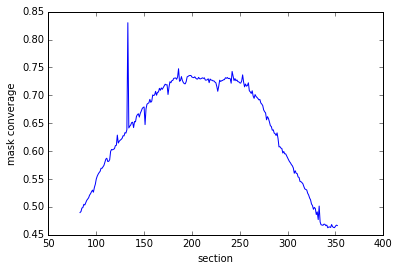

In [8]:
# This shows that a mask covers 50% to 75% of the full area, so predicting only on masks roughly halves the time.

stack = 'MD585'
image_width, image_height = metadata_cache['image_shape'][stack]
first_detect_sec, last_detect_sec = metadata_cache['section_limits'][stack]
a = image_width / 32 * image_height / 32
mask_coverage = {sec: np.count_nonzero(DataManager.load_thumbnail_mask_v2(stack=stack, section=sec))/float(a)
for sec in range(first_detect_sec, last_detect_sec+1) if not is_invalid(stack=stack, sec=sec)}
plt.plot(mask_coverage.keys(), mask_coverage.values());
plt.xlabel('section');
plt.ylabel('mask converage');

In [9]:
# for stack in all_stacks:
for stack in ['MD589']:
    
#     if stack in ['MD585', 'MD589', 'MD594', 'MD657']:
#         continue

#     image_dir = DataManager.get_image_dir(stack, resol='lossless', version='cropped')
#     download_from_s3(image_dir, is_dir=True)
    # download takes 3000 sec.

    print stack

    section_to_filename = metadata_cache['sections_to_filenames'][stack]

    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

    first_detect_sec, last_detect_sec = metadata_cache['section_limits'][stack]

    bar = show_progress_bar(first_detect_sec, last_detect_sec)
# 
#     for sec in range(151, 152):
    for sec in range(first_detect_sec, last_detect_sec+1):
#     for sec in range(143, last_detect_sec+1):
        
        if is_invalid(stack=stack, sec=sec):
            continue
            
#         if section_to_filename[sec].split('-')[1][0] == 'F':
#             continue
#         if section_to_filename[sec].split('-')[1][0] == 'N':
#             continue
                
        bar.value = sec
        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v2(stack=stack, section=sec)
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

        n = len(indices_roi)
        sys.stderr.write('%d samples.\n' % n)

        sample_locations_roi = sample_locations[indices_roi]
        
        t = time.time()
        img_fp = DataManager.get_image_filepath(stack=stack, section=sec, version='cropped_gray', resol='lossless')
        download_from_s3(img_fp)
        im = img_as_ubyte(imread(img_fp))
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s
        
#         t = time.time()
#         sat = convert_to_saturation(im)
#         del im
#         sys.stderr.write('Convert to saturation: %.2f seconds\n' % (time.time() - t)) # ~ 35s
#         sat = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='saturation'))
        

        t = time.time()

        patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
                            for x, y in sample_locations_roi]) # n x 224 x 224
        patches_mean_subtracted = patches - mean_img
        patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

#         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224 x 1
#         patches_mean_subtracted_input = np.rollaxis(patches, 3, 1) - mean_img # n x 3 x 224 x 224

        sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 20s / 140k patches

        # Increase batch_size to 500 does not save any time.
        batch_size = 256 
#         batch_size = 16

        # For mxnet 0.9.4, using 80000 patches in a NDArrayIter works but using 90000 patches causes error:
        # TypeError: Invalid type '<type 'numpy.ndarray'>' for data, should be NDArray or numpy.ndarray

        t1 = time.time()
        features = np.empty((n, output_dim))
        
#         n_each_iter = 20000
        n_each_iter = 80000
        for b in range(0, n, n_each_iter):
            data_iter = mx.io.NDArrayIter(
                patches_mean_subtracted_input[b:b+n_each_iter], 
                np.zeros((n_each_iter, ), np.int), # labels are not important since it is just feed-forward
                batch_size = batch_size,
                shuffle=False)

#             if b == 0:
#                 features = model.predict(data_iter)
#             else:
#                 features = np.vstack([features, model.predict(data_iter)])
            features[b:b+n_each_iter] = model.predict(data_iter)
        sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) # 220s-250s
        # inception-bn-blue ~80s / 30k patches
        
#         data_iter = mx.io.NDArrayIter(
#             patches_mean_subtracted_input, 
#             np.zeros((n, ), np.int), # labels are not important since it is just feed-forward
#             batch_size = batch_size,
#             shuffle=False
#         )

#         t = time.time()
#         features = model.predict(data_iter)
#         sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t))

    # The first time when CUDA needs to load model is very slow ~350s, but later runs are faster ~90s
        
    # Had to modify [model]-symbol.json according to this https://github.com/dmlc/mxnet/issues/2718
    
    # Out of memory after about 20 sections - had to modify storage code according to https://github.com/dmlc/mxnet/issues/3055
    #    - don't think increasing kPoolThreshold to over 4GB will be beneficial, 
    # since the computation time is similar to before limiting the pool, computation is most likely compute-bound.
    # Issue solved by developers.

        
#         del patches_mean_subtracted_input, patches, im
        del patches_mean_subtracted_input, patches_mean_subtracted, patches, im
        
        t = time.time()

        features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, 
                                                          section=sec)
        create_parent_dir_if_not_exists(features_fp)
        bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
        
        upload_to_s3(features_fp)

        feature_locs_fp = DataManager.get_dnn_feature_locations_filepath(stack=stack, model_name=model_name, 
                                                  section=sec)
        np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
        
        upload_to_s3(feature_locs_fp)

        sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s
        
#         del patches_mean_subtracted_input, patches, im
#         del patches_mean_subtracted_input, patches_mean_subtracted, patches, sat


Section 92.
locate patches: 0.04 seconds
29930 samples.
load image: 1.77 seconds


MD589


extract patches: 14.13 seconds


MXNetError: [16:13:49] src/storage/./pooled_storage_manager.h:84: cudaMalloc failed: out of memory

Stack trace returned 10 entries:
[bt] (0) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(+0x18667c) [0x7f1f9d23567c]
[bt] (1) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(+0xeed558) [0x7f1f9df9c558]
[bt] (2) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(+0xeef3e7) [0x7f1f9df9e3e7]
[bt] (3) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(+0xb44ec0) [0x7f1f9dbf3ec0]
[bt] (4) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(+0xb4c7a1) [0x7f1f9dbfb7a1]
[bt] (5) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(+0xb53035) [0x7f1f9dc02035]
[bt] (6) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(+0xb53724) [0x7f1f9dc02724]
[bt] (7) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(MXExecutorBindEX+0x1025) [0x7f1f9db986f5]
[bt] (8) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f2001826e40]
[bt] (9) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x2eb) [0x7f20018268ab]


In [ ]:
# transfer_data_synced(os.path.join('CSHL_patch_features', model_name, 'MD589'), 
#                     from_hostname='workstation',
#                     to_hostname='s3',
#                     is_dir=True)

# Sync with Gordon

In [ ]:
cmd = 'cd /media/yuncong/BstemAtlasData/CSHL_patch_features/Sat16ClassFinetuned/%(stack)s/ && \
rsync -r . yuncong@oasis-dm.sdsc.edu:/home/yuncong/csd395/CSHL_patch_features/Sat16ClassFinetuned/%(stack)s' % \
{'stack': stack}

os.system(cmd)